# Transfer Learning

Using Inception v3 to build a horse vs human image classifier.

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Loading the dataset

In [2]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [3]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Sample horse image:


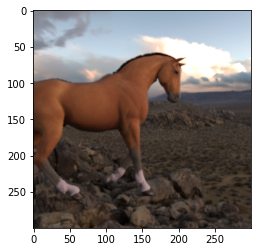


Sample human image:


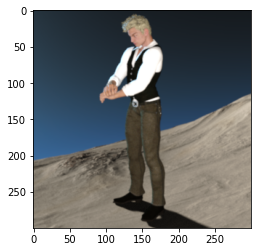

In [4]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

In [5]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


## Training and Validation Generators

In [38]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
 
  train_datagen = ImageDataGenerator( rescale =1.0/255,
                                      rotation_range = 40,
                                      width_shift_range = 0.2,
                                      height_shift_range = 0.2,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True,
                                      fill_mode = 'nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator( rescale =1.0/255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator


In [39]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Downloading the `inception V3` weights into the `/tmp/` directory:

In [40]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-26 18:39:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.5MB/s    in 4.6s    

2023-01-26 18:39:23 (18.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [41]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [42]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [43]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_376 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [44]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [45]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model

In [46]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output


In [47]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [48]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [50]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation = tf.nn.relu)(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x) 
  x = layers.Dense(1, activation = tf.nn.sigmoid)(x)       
  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs = x)

  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

In [51]:
model = create_final_model(pre_trained_model, last_output)

total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [52]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 14s - loss: 0.2333 - accuracy: 0.9211 - val_loss: 0.0320 - val_accuracy: 0.9961 - 14s/epoch - 423ms/step
Epoch 2/100
33/33 - 12s - loss: 0.0296 - accuracy: 0.9873 - val_loss: 0.0052 - val_accuracy: 0.9961 - 12s/epoch - 357ms/step
Epoch 3/100
33/33 - 10s - loss: 0.0394 - accuracy: 0.9893 - val_loss: 0.0034 - val_accuracy: 1.0000 - 10s/epoch - 313ms/step
Epoch 4/100
33/33 - 10s - loss: 0.0258 - accuracy: 0.9912 - val_loss: 0.0632 - val_accuracy: 0.9805 - 10s/epoch - 311ms/step
Epoch 5/100
33/33 - 10s - loss: 0.0290 - accuracy: 0.9893 - val_loss: 0.0461 - val_accuracy: 0.9844 - 10s/epoch - 310ms/step
Epoch 6/100
33/33 - 11s - loss: 0.0117 - accuracy: 0.9942 - val_loss: 0.0787 - val_accuracy: 0.9766 - 11s/epoch - 343ms/step
Epoch 7/100
33/33 - 10s - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.0502 - val_accuracy: 0.9883 - 10s/epoch - 310ms/step
Epoch 8/100
33/33 - 10s - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0032 - val_accuracy: 0.9961 - 10s/epoch - 311ms/step


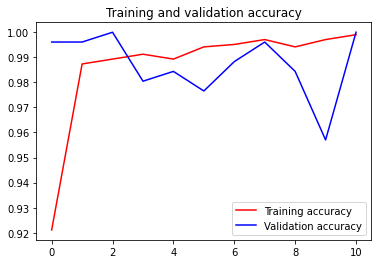

<Figure size 432x288 with 0 Axes>

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()